In [21]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import scipy as sp
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC

In [14]:
#We have used lemmatization and removed stop words if any

def text_process(text):
    lemmatiser = WordNetLemmatizer() 
    not_punct = [char for char in text if char not in string.punctuation]
    not_punct = ''.join(not_punct)
    a = ''
    i = 0
    for i in range(len(not_punct.split())):
        b = lemmatiser.lemmatize(not_punct.split()[i], pos="v")
        a = a + b + ' '

    not_stopwords = ""
    for word in a.split():
        if word.lower():
            not_stopwords = not_stopwords + word + " "
    
    return not_stopwords

In [15]:
#We have processed the text, where we have dropped rows having NaN values and used text_process function

df = pd.read_csv("./Enron_29_Features.csv").drop(["Unnamed: 0"], axis=1)
df = df[df["Email Length"].notna()]
df = df[df["Author"].notna()]
cleaned_text = df["Text"].apply(lambda row: text_process(row))
df["Processed Text"] = cleaned_text

In [16]:
#We have used LabelEncoder() to encode the class names

y = df["Folder"]
le = LabelEncoder()
y = le.fit_transform(y)

#Dropped all unrequired columns/attributes

X = df.drop(["Author", "File", "Raw Text", "Message ID", "Folder", "Text"], axis=1)

#Dropped rows having NaN values

X = X[X["Email Length"] != 0]
X = X[X["Average Word Length"].notna()]
X = X[X["Most Common Word"].notna()]
X = X.reset_index(drop=True)

In [17]:
#We are checking if still any NaN values are present, dropping if present and printing the shape after the change

for column in X.columns:
    if X[column].dropna().shape[0] != X.shape[0]:
        print(column)
        print(X[column].dropna().shape)

In [27]:
#Decision Tree Model -

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = DecisionTreeClassifier(random_state=0)
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", TfidfVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=4000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    

Y_pred = fit_model.predict(X_test_transform)
f1_dt = f1_score(y_test, Y_pred, average = "micro")    
avg_train_acc_dt = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_dt = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_dt)
print("Average Testing Accuracy:")
print(avg_test_acc_dt)
print("F1 Score:")
print(f1_dt)
print("===========================")

Round 1
Training Accuracy
0.990304246071548
Testing Accuracy
0.8140350877192982
Round 2
Training Accuracy
0.9900819078397504
Testing Accuracy
0.8184553660982948
Round 3
Training Accuracy
0.9902490666963838
Testing Accuracy
0.8054162487462387
Round 4
Training Accuracy
0.9907505432662841
Testing Accuracy
0.8154463390170511
Round 5
Training Accuracy
0.9900261882208725
Testing Accuracy
0.8239719157472417
Round 6
Training Accuracy
0.9899147489831169
Testing Accuracy
0.8174523570712137
Round 7
Training Accuracy
0.9900261882208725
Testing Accuracy
0.8109327983951855
Round 8
Training Accuracy
0.9905276647907728
Testing Accuracy
0.8009027081243731
Round 9
Training Accuracy
0.9898590293642392
Testing Accuracy
0.8244734202607823
Round 10
Training Accuracy
0.9896361508887279
Testing Accuracy
0.8129388164493481
Average Training Accuracy:
0.9901375734342569
Average Testing Accuracy:
0.8144025057629026
F1 Score:
0.8129388164493482


In [28]:
#Multinomial Naive Bayes Model Model -

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", TfidfVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=4000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    

Y_pred = fit_model.predict(X_test_transform)
f1_mnb = f1_score(y_test, Y_pred, average = "micro")    
avg_train_acc_mnb = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_mnb = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_mnb)
print("Average Testing Accuracy:")
print(avg_test_acc_mnb)
print("F1 Score:")
print(f1_mnb)
print("===========================")

Round 1
Training Accuracy
0.808313830380029
Testing Accuracy
0.7904761904761904
Round 2
Training Accuracy
0.806987240207277
Testing Accuracy
0.7868605817452357
Round 3
Training Accuracy
0.8058728478297208
Testing Accuracy
0.7968906720160481
Round 4
Training Accuracy
0.8077673148715663
Testing Accuracy
0.7858575727181545
Round 5
Training Accuracy
0.8079344737281997
Testing Accuracy
0.7953861584754263
Round 6
Training Accuracy
0.8083802306792222
Testing Accuracy
0.7928786359077231
Round 7
Training Accuracy
0.8074887167771773
Testing Accuracy
0.7808425275827482
Round 8
Training Accuracy
0.8088817072491225
Testing Accuracy
0.7733199598796389
Round 9
Training Accuracy
0.8070986794450326
Testing Accuracy
0.8004012036108324
Round 10
Training Accuracy
0.8086588287736112
Testing Accuracy
0.7838515546639919
Average Training Accuracy:
0.8077383869940957
Average Testing Accuracy:
0.7886765057075988
F1 Score:
0.7838515546639919


In [29]:
#Random Forest Classifier Model -
# Average Training Accuracy:
# 0.9901375734342569
# Average Testing Accuracy:
# 0.8695653376168607
#random_state=3 ^^^^
# Average Training Accuracy:
# 0.9901375734342569
# Average Testing Accuracy:
# 0.8703677197004549

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = RandomForestClassifier()
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", TfidfVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=4000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    
Y_pred = fit_model.predict(X_test_transform)
f1_rf = f1_score(y_test, Y_pred, average = "micro")
avg_train_acc_rf = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_rf = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_rf)
print("Average Testing Accuracy:")
print(avg_test_acc_rf)
print("F1 Score:")
print(f1_rf)
print("===========================")

Round 1
Training Accuracy
0.990304246071548
Testing Accuracy
0.8726817042606516
Round 2
Training Accuracy
0.9900819078397504
Testing Accuracy
0.8746238716148446
Round 3
Training Accuracy
0.9902490666963838
Testing Accuracy
0.8590772316950852
Round 4
Training Accuracy
0.9907505432662841
Testing Accuracy
0.8635907723169508
Round 5
Training Accuracy
0.9900261882208725
Testing Accuracy
0.8756268806419257
Round 6
Training Accuracy
0.9899147489831169
Testing Accuracy
0.8625877632898696
Round 7
Training Accuracy
0.9900261882208725
Testing Accuracy
0.8610832497492478
Round 8
Training Accuracy
0.9905276647907728
Testing Accuracy
0.8746238716148446
Round 9
Training Accuracy
0.9898590293642392
Testing Accuracy
0.8746238716148446
Round 10
Training Accuracy
0.9896361508887279
Testing Accuracy
0.8696088264794383
Average Training Accuracy:
0.9901375734342569
Average Testing Accuracy:
0.8688128043277704
F1 Score:
0.8696088264794383


In [30]:
#Support Vector Classification Model -

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = svm.SVC(kernel = "linear")
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", TfidfVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=4000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    
Y_pred = fit_model.predict(X_test_transform)
f1_svc = f1_score(y_test, Y_pred, average = "micro")
avg_train_acc_svc = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_svc = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_svc)
print("Average Testing Accuracy:")
print(avg_test_acc_svc)
print("F1 Score:")
print(f1_svc)
print("===========================")

Round 1
Training Accuracy
0.9237155912180988
Testing Accuracy
0.8681704260651629
Round 2
Training Accuracy
0.9237198417562824
Testing Accuracy
0.8736208625877633
Round 3
Training Accuracy
0.9239984398506714
Testing Accuracy
0.872617853560682
Round 4
Training Accuracy
0.9236084025185268
Testing Accuracy
0.8585757271815446
Round 5
Training Accuracy
0.9238870006129158
Testing Accuracy
0.8686058174523571
Round 6
Training Accuracy
0.9217139354766813
Testing Accuracy
0.8731193580742227
Round 7
Training Accuracy
0.9238870006129158
Testing Accuracy
0.8686058174523571
Round 8
Training Accuracy
0.923831280994038
Testing Accuracy
0.8480441323971916
Round 9
Training Accuracy
0.922995486710871
Testing Accuracy
0.8841524573721163
Round 10
Training Accuracy
0.9246670752772052
Testing Accuracy
0.8681043129388164
Average Training Accuracy:
0.9236024055028205
Average Testing Accuracy:
0.8683616765082214
F1 Score:
0.8681043129388164


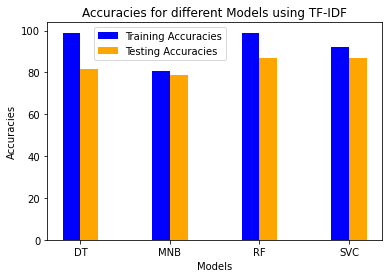

In [31]:
#We will plot the graph to show the comparision between the accuracies for different models

all_avg_train_acc = [avg_train_acc_dt*100, avg_train_acc_mnb*100, avg_train_acc_rf*100, avg_train_acc_svc*100]
all_avg_test_acc = [avg_test_acc_dt*100, avg_test_acc_mnb*100, avg_test_acc_rf*100, avg_test_acc_svc*100]
x_axis = ["DT", "MNB", "RF", "SVC"]
x = np.arange(4)
width = 0.2
figure, axis = plt.subplots()
rect_a = axis.bar(x - width/2, all_avg_train_acc, width, label = "Training Accuracies", color = "b")
rect_b = axis.bar(x + width/2, all_avg_test_acc, width, label = "Testing Accuracies", color = "orange")
axis.set_ylabel("Accuracies")
axis.set_title("Accuracies for different Models using TF-IDF")
axis.set_xticks(x)
axis.set_xticklabels(x_axis)
axis.set_xlabel("Models")
axis.legend(loc = "upper right", bbox_to_anchor=(0.55, 1))

plt.show()